# Practical 2: Calculating gravity disturbances from absolute gravity

In practical 1, we learned how to process the raw gravimeter relative readings into absolute gravity values. These data are affected by the entire mass of the Earth, which masks the small variations associated with crustal geological structures (our targets). So we have to **remove the effect of all other masses** before we can interpret the data in terms of crustal geology.

We'll do this in the following steps:

1. Elimintate the effect of most of the Earth's mass and rotation by removing **normal gravity**
2. Remove the effect of topography above the ellipsoid by removing the gravity of a **Bouguer plate**
3. Isolate shallower and local crustal structures by removing a **regional field**

The **residual field** that is left after these steps should be close to the gravitational attraction resulting from our geological structures. Of course, the way we calculate all of them relies on approximations and more accurate methods exist but would be more than we can cover in a single practical.

## Goals

* Implement the normal gravity and Bouguer plate calculations in Python
* Calculate a residual gravity disturbance around Cape Town
* Correlate the observed residual field to known local geology

## Data 

For this practical, you'll need:

* The absolute gravity values for the survey around Cape Town. This should have been produced as an output of practical 1. You can also download a CSV file with calculated values: [`cape-town-survey-absolute.csv`](https://raw.githubusercontent.com/leouieda/gravity-processing/main/data/cape-town-survey-absolute.csv) 

Place the file into the **same folder as this notebook**. Your should folder structure now should look something like this:

```
gravity-practicals/
├── cape-town-survey-absolute.csv
├── practical2.ipynb
├── cape-town-surveys/
│   ├── cape-town-gravity-day-1.csv
│   ├── cape-town-gravity-day-2.csv
│   ├── cape-town-gravity-day-3.csv
│   ├── cape-town-gravity-day-4.csv
│   └── cape-town-gravity-day-5.csv
├── gravimeter-scaling.csv
└── practical1.ipynb
```

The first few lines of the data file:

```
longitude,latitude,easting,northing,elevation,gravity
18.34444,-34.12971,255105.43,6220276.33,32.2,979656.12
18.37418,-34.19583,258037.64,6213013.01,18.4,979666.46
18.40388,-34.23972,260899.25,6208214.71,25.0,979671.03
18.50333,-34.03555,269506.57,6231090.44,15.1,979640.22
```

The data are a subset of the public domain data for Southern Africa distributed by the [NOAA National Centers for Environmental Information](https://www.ngdc.noaa.gov/).

## Survey location

The surveys were caried out near Cape Town, South Africa. Most points fall around False Bay and the Cape Peninsula, stretching a bit northwards. See the Wikipedia page on the [Geology of Cape Town](https://en.wikipedia.org/wiki/Geology_of_Cape_Town) for details on the geologic context.

In [1]:
from IPython.display import IFrame

In [2]:
IFrame(src="https://www.google.com/maps/d/embed?mid=1FunoJz1_shZ3wxfNFpg5FH33qkOg3tie", width=800, height=600)

## Import the required libraries

To deal with this type of tabular data, all we need are numpy and matplotlib.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

## Read and plot the data

First thing we need to do is read in and plot the absolute gravity data. We'll do this with numpy using the same arguments we used previously. While we're at it, we'll also place each column into a separate variable to make them easier to use.

In [6]:
data = np.loadtxt("cape-town-survey-absolute.csv", delimiter=",", skiprows=1)
# Print the first few rows
print(data[:10, :])

[[ 1.83444400e+01 -3.41297100e+01  2.55105430e+05  6.22027633e+06
   3.22000000e+01  9.79656120e+05]
 [ 1.83741800e+01 -3.41958300e+01  2.58037640e+05  6.21301301e+06
   1.84000000e+01  9.79666460e+05]
 [ 1.84038800e+01 -3.42397200e+01  2.60899250e+05  6.20821471e+06
   2.50000000e+01  9.79671030e+05]
 [ 1.84111200e+01 -3.41644400e+01  2.61353990e+05  6.21658203e+06
   2.28700000e+02  9.79616110e+05]
 [ 1.84255700e+01 -3.42977800e+01  2.63060440e+05  6.20182521e+06
   1.04000000e+02  9.79662740e+05]
 [ 1.84586000e+01 -3.42050000e+01  2.65844020e+05  6.21219318e+06
   8.90000000e+00  9.79662480e+05]
 [ 1.84861100e+01 -3.40852800e+01  2.68052070e+05  6.22553549e+06
   1.90000000e+01  9.79642880e+05]
 [ 1.85033300e+01 -3.40355500e+01  2.69506570e+05  6.23109044e+06
   1.51000000e+01  9.79640220e+05]
 [ 1.85438800e+01 -3.40786100e+01  2.73365760e+05  6.22640498e+06
   3.47000000e+01  9.79640330e+05]
 [ 1.85930600e+01 -3.40491600e+01  2.77827860e+05  6.22977946e+06
   5.96000000e+01  9.7963

In [8]:
# An easy way to unpack all columns is to transpose the array (columns become rows)
longitude, latitude, easting, northing, elevation, gravity = data.T

Text(0.5, 1.0, 'Absolute gravity')

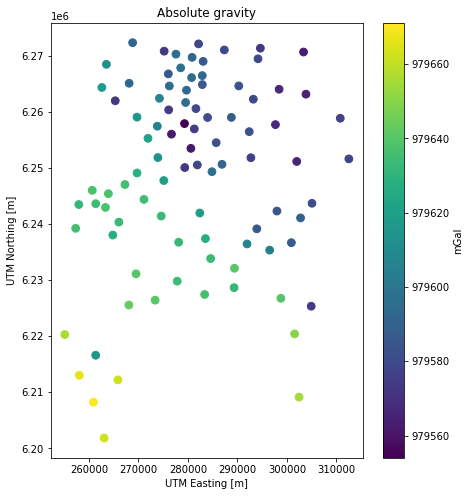

In [9]:
plt.figure(figsize=(7, 8))
plt.scatter(easting, northing, c=gravity, s=60)
plt.colorbar(label="mGal")
plt.xlabel("UTM Easting [m]")
plt.ylabel("UTM Northing [m]")
plt.title("Absolute gravity")

Text(0.5, 1.0, 'Absolute gravity')

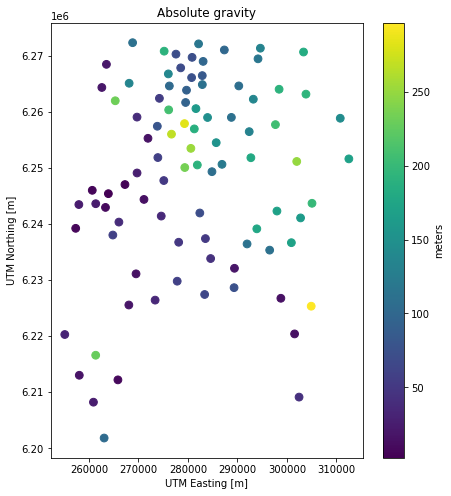

In [10]:
plt.figure(figsize=(7, 8))
plt.scatter(easting, northing, c=elevation, s=60)
plt.colorbar(label="meters")
plt.xlabel("UTM Easting [m]")
plt.ylabel("UTM Northing [m]")
plt.title("Absolute gravity")

## Calculate normal gravity: Part 1

The gravity measured at the stations includes:

* The attraction of all masses of the Earth (absolutely everything)
* The centrifugal acceleration due to the Earth's rotation

To isolate the effect of local geology, we have to remove as much of this signal as we can. The first step is to approximate the Earth for a **rotating oblate ellipsoid**:

<img src="https://upload.wikimedia.org/wikipedia/commons/9/98/Ellipsoid_revolution_oblate_aac.svg" style="width: 500px; margin: 10px auto;">
<p style="text-align: center;">
Figure: Oblate ellipsoid with semimajor axis $a$, semiminor axis $c$, and origin at $O$. Credit: <a href="https://commons.wikimedia.org/wiki/File:Ellipsoid_revolution_oblate_aac.svg">Peter Mercator</a> (CC-BY-SA)    
</p>


The ellipsoid should have:

1. The same mass as the Earth
1. Rotate at the same angular velocity
1. Have the approximate dimensions of the Earth

If we can calculate the gravity of such an ellipsoid and remove it from our data, we can remove the vast majority of the signal, as well as the centrifugal acceleration (since the ellipsoid is also rotating). The gravity acceleration (gravitational + centrifugal) of a reference ellipsoid is called **normal gravity** and is often represented as $\gamma$.

We can calculate normal gravity **on the surface of the ellipsoid** using the [Somigliana equation](https://en.wikipedia.org/wiki/Theoretical_gravity#Somigliana_Formula):

$$
\gamma_0 (\theta) = \dfrac{a\ \gamma_a \cos^2 \theta + c\ \gamma_c \sin^2 \theta}{\sqrt{a^2 \cos^2 \theta + c^2 \sin^2 \theta}}
$$

in which $\theta$ is the latitude, $a$ and $c$ are the semimajor and seminor axis, and $\gamma_a$ and $\gamma_c$ are the normal gravity at the equator and the poles, respectively. It may seem strange that we need to know normal gravity at the pole and equator in order to calculate normal gravity elsewhere but these values can be calculated from the properties of the ellipsoid (axis, mass, and angular velocity).

For this practical, we will use the [WGS84 reference ellipsoid](https://en.wikipedia.org/wiki/World_Geodetic_System):

| | WGS84 |
|:----|:----|
| semimajor axis $a$ | 6378137 m |
| semiminor axis $c$ | 6356752 m |
| gravity at the equator $\gamma_a$ | 978032.53359 mGal |
| gravity at the poles $\gamma_c$ | 983218.49379 mGal |

In [11]:
semimajor = 6_378_137
semiminor = 6_356_752
# Convert to m/s² so the units are compatible
gamma_equator = 9.7803253359
gamma_pole = 9.8321849379

In [15]:
cos_lat2 = np.cos(np.radians(latitude)) ** 2
sin_lat2 = np.sin(np.radians(latitude)) ** 2
normal_gravity_surface = 1e5 * (
    (semimajor * gamma_equator * cos_lat2 + semiminor * gamma_pole * sin_lat2) /
    np.sqrt(semimajor ** 2 * cos_lat2 + semiminor ** 2 * sin_lat2)
)

Text(0.5, 1.0, 'Absolute gravity')

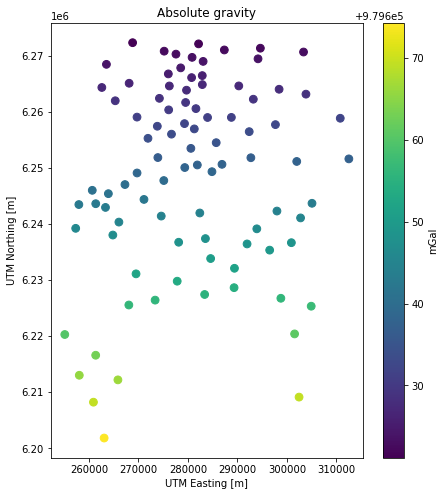

In [16]:
plt.figure(figsize=(7, 8))
plt.scatter(easting, northing, c=normal_gravity_surface, s=60)
plt.colorbar(label="mGal")
plt.xlabel("UTM Easting [m]")
plt.ylabel("UTM Northing [m]")
plt.title("Absolute gravity")